In [1]:
import cv2
import os
from tqdm import tqdm 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import models, layers

In [2]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df

In [9]:
data_dir = r"C:\Users\John Justine\Downloads\archive (6)\train"
train_df = loading_the_data(data_dir)

train_df

,filepaths,labels
0,C:\Users\John Justine\Downloads\archive (6)\tr...,benign
1,C:\Users\John Justine\Downloads\archive (6)\tr...,benign
2,C:\Users\John Justine\Downloads\archive (6)\tr...,benign
3,C:\Users\John Justine\Downloads\archive (6)\tr...,benign
4,C:\Users\John Justine\Downloads\archive (6)\tr...,benign
...,...,...
2632,C:\Users\John Justine\Downloads\archive (6)\tr...,malignant
2633,C:\Users\John Justine\Downloads\archive (6)\tr...,malignant
2634,C:\Users\John Justine\Downloads\archive (6)\tr...,malignant
2635,C:\Users\John Justine\Downloads\archive (6)\tr...,malignant


In [12]:
data_dir = r"C:\Users\John Justine\Downloads\archive (6)\test"
ts_df = loading_the_data(data_dir)

ts_df

,filepaths,labels
0,C:\Users\John Justine\Downloads\archive (6)\te...,benign
1,C:\Users\John Justine\Downloads\archive (6)\te...,benign
2,C:\Users\John Justine\Downloads\archive (6)\te...,benign
3,C:\Users\John Justine\Downloads\archive (6)\te...,benign
4,C:\Users\John Justine\Downloads\archive (6)\te...,benign
...,...,...
655,C:\Users\John Justine\Downloads\archive (6)\te...,malignant
656,C:\Users\John Justine\Downloads\archive (6)\te...,malignant
657,C:\Users\John Justine\Downloads\archive (6)\te...,malignant
658,C:\Users\John Justine\Downloads\archive (6)\te...,malignant


Data Preprocessing

In [15]:

def create_datagen():
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values
        rotation_range=15,  # Random rotations
        horizontal_flip=True,  # Random horizontal flips
        zoom_range=0.1  # Random zoom
    )

    # For testing, only rescaling is needed
    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, test_datagen

def load_data_with_generator(train_dir, test_dir, img_size=64, batch_size=32):
    train_datagen, test_datagen = create_datagen()

    # Create a training data generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary' 
    )
    
    # Create a testing data generator
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary' 
    )

    return train_generator, test_generator

# Define your directories
train_dir = r"C:\Users\John Justine\Downloads\archive (6)\train"
test_dir = r"C:\Users\John Justine\Downloads\archive (6)\test"

train_generator, test_generator = load_data_with_generator(train_dir, test_dir)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


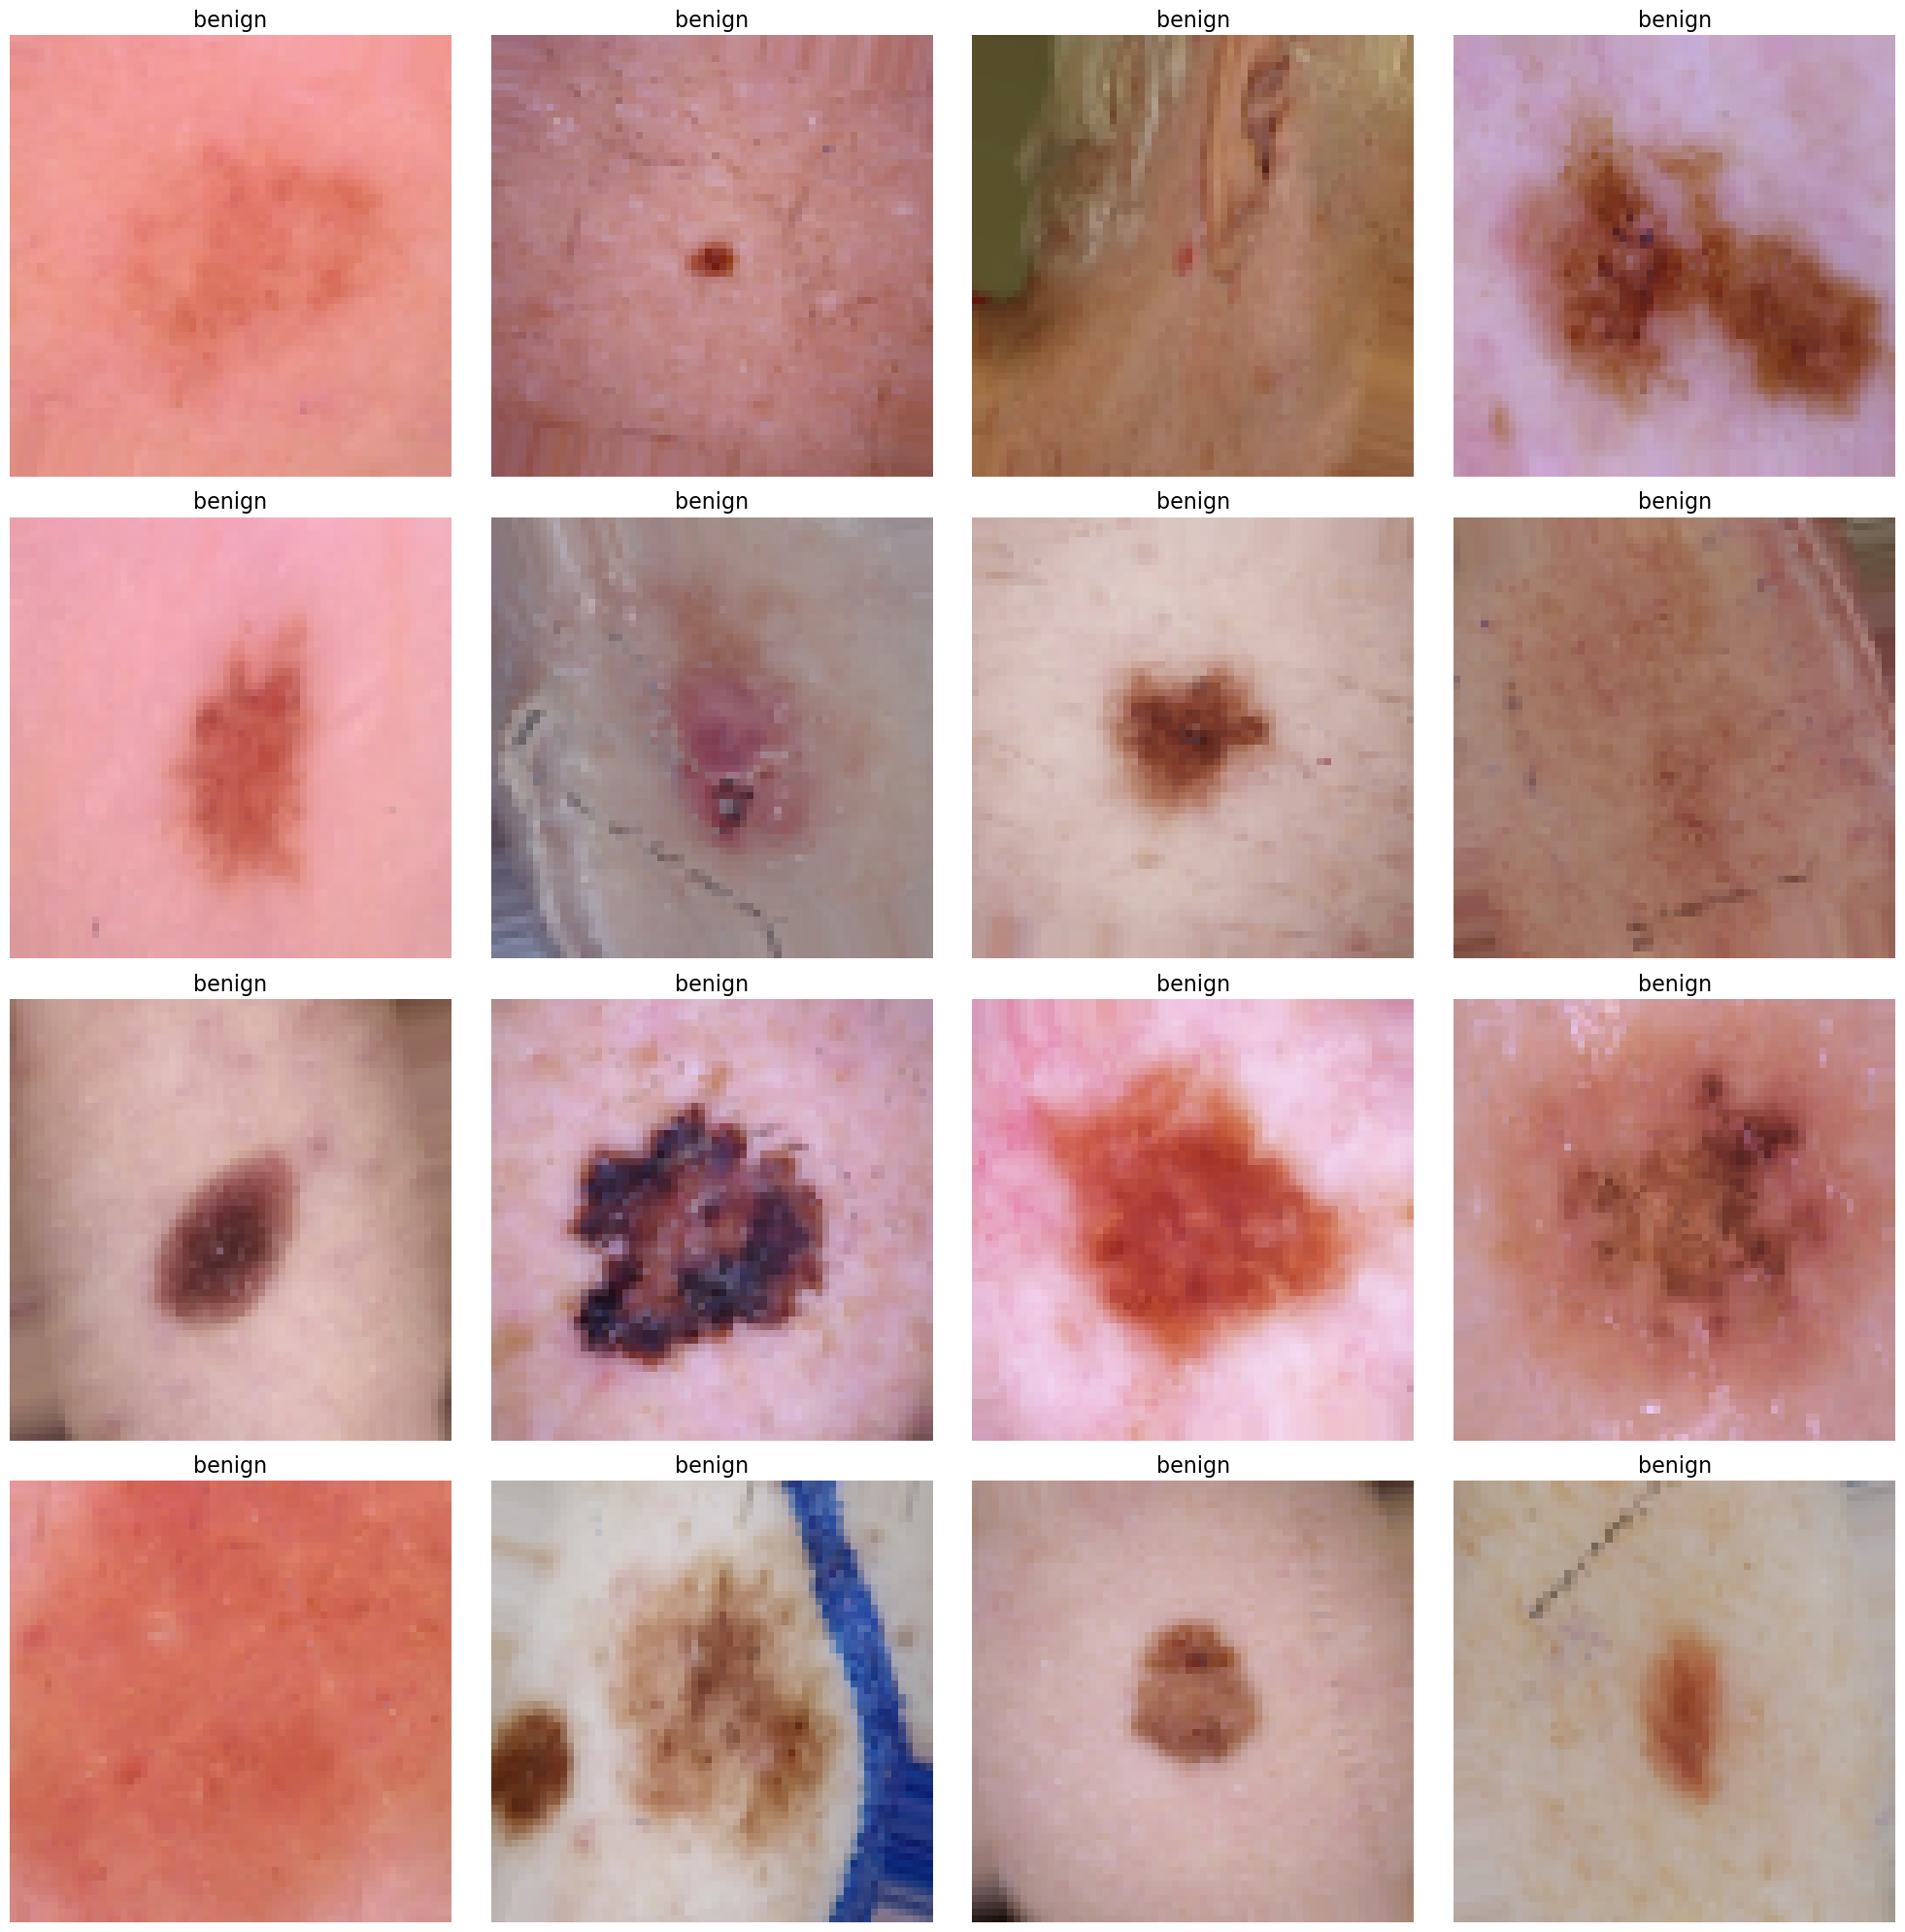

In [16]:
def display_sample_images(generator):
    """
    Display a batch of images from a data generator.
    """
    images, labels = next(generator)  
    classes = list(generator.class_indices.keys())  
    
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i]) 
        class_name = classes[index]
        plt.title(class_name, color='black', fontsize=16)
        plt.axis('off')
        if i == 15:  
            break
    plt.tight_layout()
    plt.show()

display_sample_images(train_generator)

Custom CNN

In [17]:
def build_custom_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])
    return model

custom_cnn_model = build_custom_cnn((64, 64, 3), 1)

custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

custom_cnn_model.summary()

C:\Users\John Justine\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,176,385 (4.49 MB)

 Trainable params: 1,176,385 (4.49 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_custom_cnn = custom_cnn_model.fit(
    train_generator, 
    validation_data=test_generator, 
    epochs=10,  
    batch_size=32)  

Epoch 1/10


C:\Users\John Justine\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.5627 - loss: 0.6569 - val_accuracy: 0.7515 - val_loss: 0.4763
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.7440 - loss: 0.5242 - val_accuracy: 0.7485 - val_loss: 0.4858
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - accuracy: 0.7870 - loss: 0.4547 - val_accuracy: 0.7864 - val_loss: 0.4153
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.7777 - loss: 0.4566 - val_accuracy: 0.7864 - val_loss: 0.4049
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step - accuracy: 0.7892 - loss: 0.4305 - val_accuracy: 0.7909 - val_loss: 0.4025
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.8127 - loss: 0.3933 - val_accuracy: 0.7818 - val_loss: 0.4026
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - accuracy: 0.7973 - loss: 0.4126 - val_accuracy: 0.7742 - val_loss: 0.4040
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 0.7839 - loss: 0.4241 - val_accuracy: 0.778

In [19]:
test_generator.reset() 
predictions_custom_cnn = custom_cnn_model.predict(test_generator)
predicted_classes_custom_cnn = (predictions_custom_cnn > 0.5).astype(int)
true_classes = test_generator.classes

print("Custom CNN Model Evaluation")
print(classification_report(true_classes, predicted_classes_custom_cnn))

fpr, tpr, thresholds = roc_curve(true_classes, predictions_custom_cnn)
roc_auc = auc(fpr, tpr)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step
Custom CNN Model Evaluation
              precision    recall  f1-score   support

           0       0.54      0.37      0.44       360
           1       0.45      0.63      0.53       300

    accuracy                           0.49       660
   macro avg       0.50      0.50      0.48       660
weighted avg       0.50      0.49      0.48       660



In [20]:
def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])

    return model

vgg16_model = build_vgg16_model((64, 64, 3), 1)

vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg16_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ ?                           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
history_vgg16 = vgg16_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10, 
    batch_size=32  
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 50s 562ms/step - accuracy: 0.7176 - loss: 0.5594 - val_accuracy: 0.8121 - val_loss: 0.4024
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 46s 547ms/step - accuracy: 0.8163 - loss: 0.4137 - val_accuracy: 0.8091 - val_loss: 0.3839
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 50s 586ms/step - accuracy: 0.8135 - loss: 0.4085 - val_accuracy: 0.8288 - val_loss: 0.3798
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 47s 554ms/step - accuracy: 0.8098 - loss: 0.3916 - val_accuracy: 0.8197 - val_loss: 0.3939
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 47s 556ms/step - accuracy: 0.8205 - loss: 0.3696 - val_accuracy: 0.8333 - val_loss: 0.3472
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 46s 545ms/step - accuracy: 0.8329 - loss: 0.3648 - val_accuracy: 0.8242 - val_loss: 0.3561
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 45s 534ms/step - accuracy: 0.8444 - loss: 0.3455 - val_accuracy: 0.8348 - val_loss: 0.3416
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 45s 536ms/step - accuracy: 0.8528 - loss: 0.3429 - val_accu

In [26]:
test_loss, test_acc = vgg16_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8416 - loss: 0.3234
Test accuracy: 0.8454545736312866, Test loss: 0.3388248085975647


In [27]:
test_generator.reset()  
predictions_vgg16 = vgg16_model.predict(test_generator)
predicted_classes_vgg16 = (predictions_vgg16 > 0.5).astype(int)

print("VGG16 Model Evaluation")
print(classification_report(true_classes, predicted_classes_vgg16))

fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(true_classes, predictions_vgg16)
roc_auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)

21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
VGG16 Model Evaluation
              precision    recall  f1-score   support

           0       0.58      0.54      0.56       360
           1       0.49      0.53      0.51       300

    accuracy                           0.54       660
   macro avg       0.54      0.54      0.53       660
weighted avg       0.54      0.54      0.54       660



In [28]:
def build_vgg19_model(input_shape, num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])

    return model

vgg19_model = build_vgg19_model((64, 64, 3), 1)

vgg19_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
history_vgg19 = vgg19_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  
    batch_size=32  
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.6807 - loss: 0.6163 - val_accuracy: 0.8197 - val_loss: 0.4219
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.7857 - loss: 0.4569 - val_accuracy: 0.8091 - val_loss: 0.4007
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8008 - loss: 0.4233 - val_accuracy: 0.8182 - val_loss: 0.3857
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.7900 - loss: 0.4077 - val_accuracy: 0.8227 - val_loss: 0.3577
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.8091 - loss: 0.3925 - val_accuracy: 0.8394 - val_loss: 0.3520
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.8048 - loss: 0.3819 - val_accuracy: 0.8364 - val_loss: 0.3453
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.8252 - loss: 0.3567 - val_accuracy: 0.8348 - val_loss: 0.3475
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.8280 - loss: 0.3741 - val_accuracy: 0.8076 - v

In [30]:
test_loss, test_acc = vgg19_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 616ms/step - accuracy: 0.8155 - loss: 0.3571
Test accuracy: 0.8196969628334045, Test loss: 0.35541221499443054


In [31]:
test_generator.reset()  
predictions_vgg19 = vgg19_model.predict(test_generator)
predicted_classes_vgg19 = (predictions_vgg19 > 0.5).astype(int)

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 636ms/step


In [32]:
print("VGG19 Model Evaluation")
print(classification_report(true_classes, predicted_classes_vgg19))

fpr_vgg19, tpr_vgg19, thresholds_vgg19 = roc_curve(true_classes, predictions_vgg19)
roc_auc_vgg19 = auc(fpr_vgg19, tpr_vgg19)

VGG19 Model Evaluation
              precision    recall  f1-score   support

           0       0.57      0.46      0.51       360
           1       0.47      0.57      0.52       300

    accuracy                           0.51       660
   macro avg       0.52      0.52      0.51       660
weighted avg       0.52      0.51      0.51       660



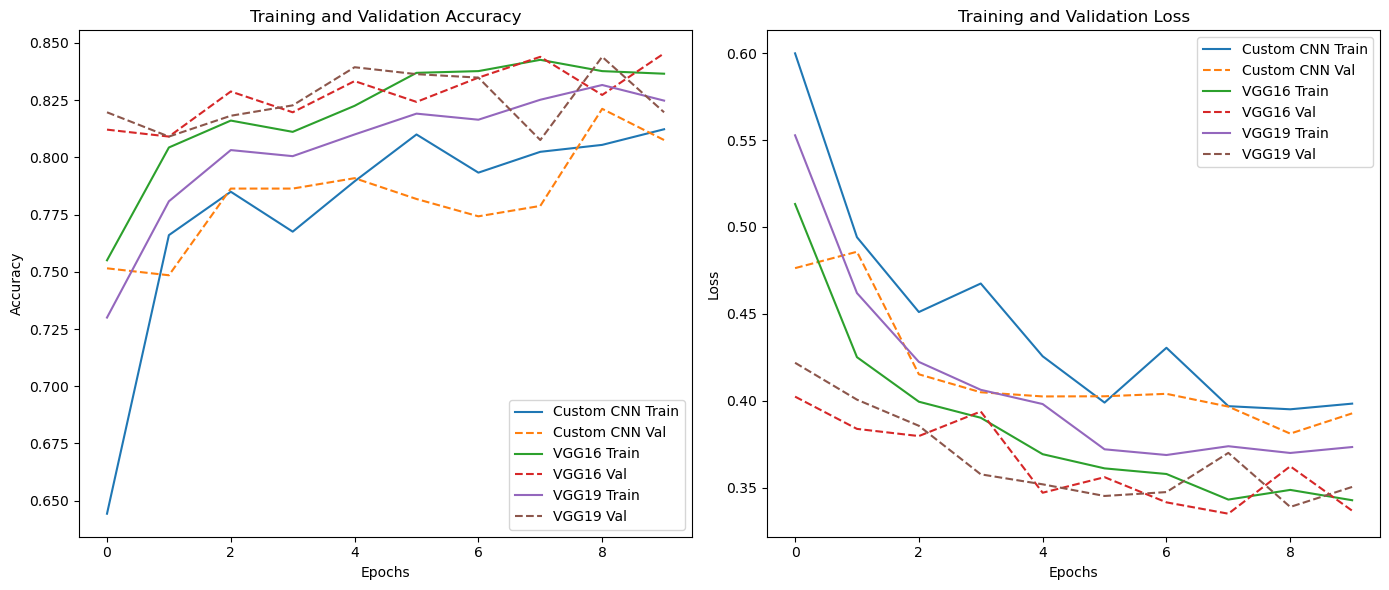

In [33]:
def plot_model_history(model_histories, labels, metric='accuracy'):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    for history, label in zip(model_histories, labels):
        plt.plot(history.history[metric], label=f'{label} Train')
        plt.plot(history.history[f'val_{metric}'], '--', label=f'{label} Val')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.subplot(1, 2, 2)
    for history, label in zip(model_histories, labels):
        plt.plot(history.history['loss'], label=f'{label} Train')
        plt.plot(history.history['val_loss'], '--', label=f'{label} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_model_history(
    [history_custom_cnn, history_vgg16, history_vgg19],
    ['Custom CNN', 'VGG16', 'VGG19']
)


Custom CNN Model Confusion Matrix


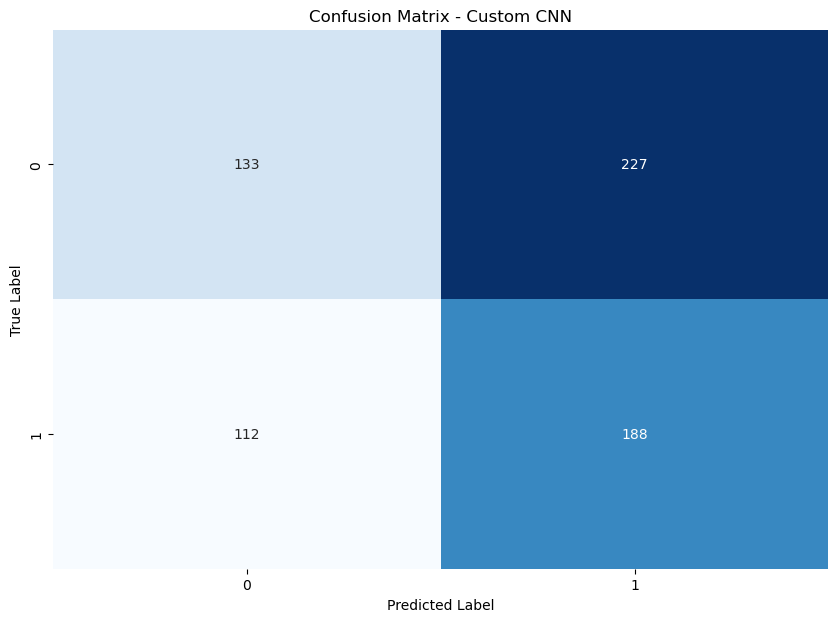

VGG16 Model Confusion Matrix


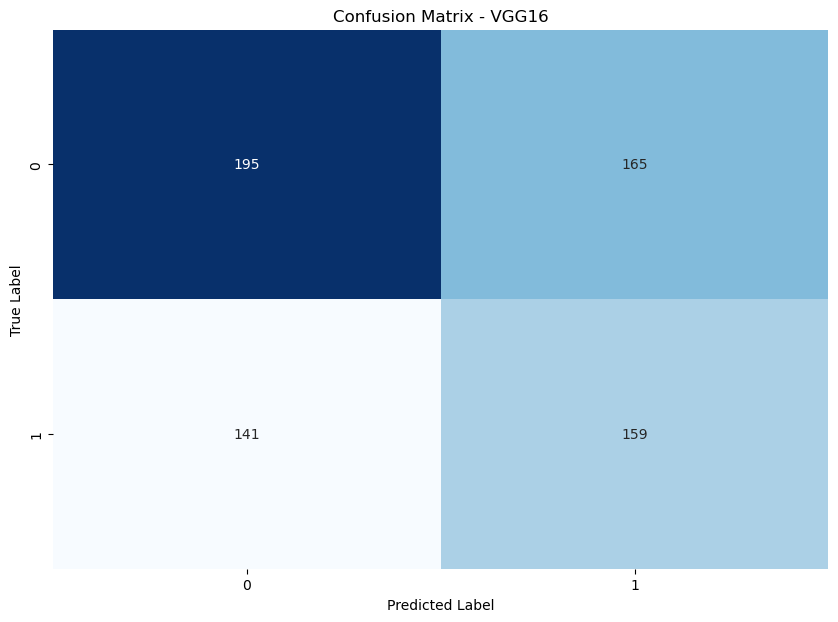

VGG19 Model Confusion Matrix


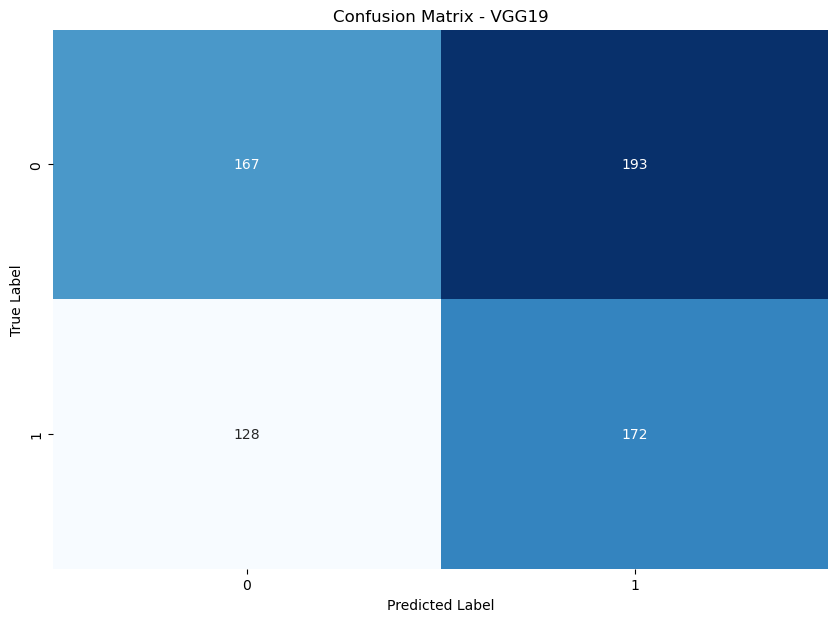

In [34]:
def plot_confusion_matrix(true_classes, predicted_classes, title='Confusion Matrix'):
    matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

print("Custom CNN Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_custom_cnn, 'Confusion Matrix - Custom CNN')

print("VGG16 Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_vgg16, 'Confusion Matrix - VGG16')

print("VGG19 Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_vgg19, 'Confusion Matrix - VGG19')

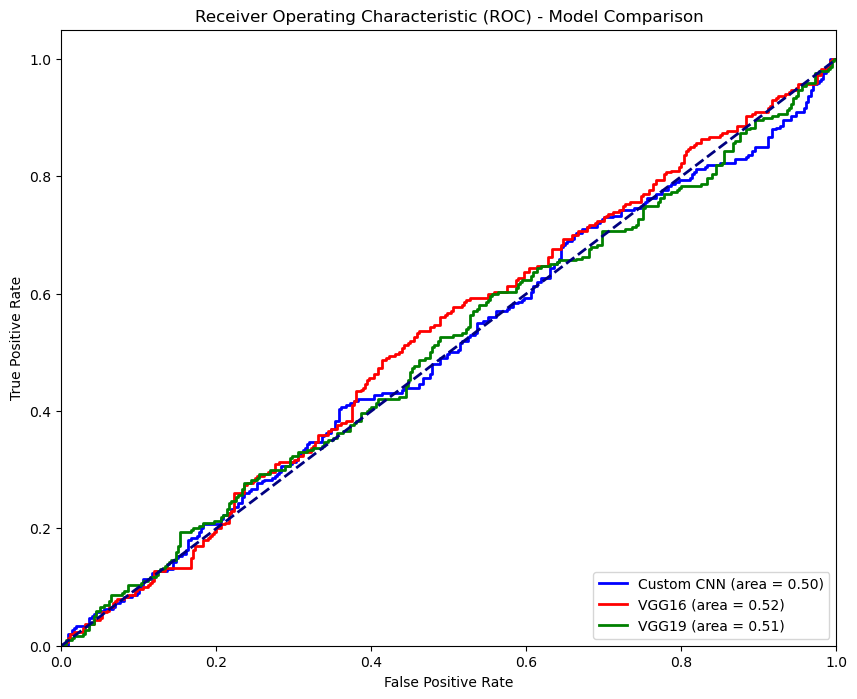

In [35]:
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'Custom CNN (area = {roc_auc:.2f})')

plt.plot(fpr_vgg16, tpr_vgg16, color='red', lw=2, label=f'VGG16 (area = {roc_auc_vgg16:.2f})')

plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label=f'VGG19 (area = {roc_auc_vgg19:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Model Comparison')
plt.legend(loc="lower right")
plt.show()